<a href="https://colab.research.google.com/github/Santiagokmids/RecommendationsSteam/blob/master/RecommendationSteam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#manejo de los datos
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import json
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import MinMaxScaler       
from sklearn.cluster import KMeans                   
from sklearn.metrics import confusion_matrix         
from copy import deepcopy                            #Permite hacer copias profundas. 
from sklearn.metrics import pairwise_distances_argmin_min

#Pipelines
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.pipeline import make_pipeline

#visualización
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer     #Permite obtener la gráfica del codo para tres métricas diferentes (distorsión, silueta, CH).
from yellowbrick.cluster import SilhouetteVisualizer #Permite obtener la gráfica de las siluetas de cada grupo. 

# styles
# plt.style.use("gaplot")
# aquí el 11 me saca el número de columnas teniendo en cuenta el cero
# el 6 el número de filas teniendo en cuenta el cero
rcParams['figure.figsize'] = (12, 6)


#**Importar archivos**
***
Se realizará el proceso necesario para descargar los archivos que se utilizarán en el proyecto desde la plataforma Kaggle

## Instalando Kaggle

In [ ]:
!pip install -q kaggle


## Importando el sistema de archivos que provee colab


In [ ]:
from google.colab import files

## Creación y carga de la API


In [ ]:
#desde account en Kaggle toca descargar el API dándole click donde dice Create en perfil

#se carga el archivo de forma local
files.upload()

#se crea una carpeta
! mkdir ~/.kaggle

#Se copia el archivo con las credenciales anteriores
! cp kaggle.json ~/.kaggle

#se cambian los permisos para permitir lectura
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


##Probar conexión

In [ ]:
! kaggle datasets list

ref                                                                   title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
arnabchaki/data-science-salaries-2023                                 Data Science Salaries 2023 💸                         25KB  2023-04-13 09:55:16          22971        639  1.0              
mauryansshivam/netflix-ott-revenue-and-subscribers-csv-file           Netflix OTT Revenue and Subscribers (CSV File)        2KB  2023-05-13 17:40:23           1248         29  1.0              
darshanprabhu09/stock-prices-for                                      Stock prices of Amazon , Microsoft , Google, Apple   85KB  2023-05-16 15:17:16           1185         33  1.0              
fatihb/coffee-quality-data-cqi

## Descargar dataset desde Kaggle


Se le da click al botón **New Notebook** desde el Dataset que quiero descargar y luego le doy click en **"Copy API command"**

In [ ]:
#comando para descargar dataset
! kaggle datasets download -d antonkozyriev/game-recommendations-on-steam

#ruta del dataset: kaggle datasets download -d themrityunjaypathak/most-subscribed-1000-youtube-channels



 99% 228M/231M [00:11<00:00, 24.4MB/s]
100% 231M/231M [00:11<00:00, 21.1MB/s]


## Descomprimir archivo

In [ ]:
! unzip /content/game-recommendations-on-steam.zip

Archive:  /content/game-recommendations-on-steam.zip
  inflating: games.csv               
  inflating: games_metadata.json     
  inflating: recommendations.csv     
  inflating: users.csv               


## Asignar archivo

In [ ]:
df_games = pd.read_csv('/content/games.csv')

df_users = pd.read_csv('/content/users.csv')

df_recommendations = pd.read_csv('/content/recommendations.csv')

# **Limpieza de datos**
***
Con base en el análisis previamente hecho sobre los diferentes conjuntos de datos se encontró pertinente realizar los siguientes cambios al conjunto de datos principal:
* Para el conjunto de datos de usuarios es necesario: 
  - Eliminar las columnas "products" y "reviews", ya que es información poco relevante.
* Para el conjunto de datos de recomendaciones es necesario:
  - Eliminr las columnas "helpful", "funny", "hours" y "date".
* Para el conjunto de datos de juegos es necesario:
  - Eliminar las columnas "steam_deck", "price_original" y "discount".
  - Transformar las columnas booleanas "win",	"mac", y "linux" a numéricas.
  - Crear una nueva columna con los géneros a los que pertenece un juego.
  - Realizar one hot encoding para la colunma "genre".
  - Realizar label encoding para la columns "rating".
  - Convertir el precio de los juegos a pesos colombianos.
  - Realizar un análisis de lenguaje natural a la columna "description".

En general para los tres dataset, es necesario tratar los valores nulos, los valores duplicados y los datos atípicos.

Para finalizar, se hace indispensable implementar tres modelos diferentes que son:
* K-Means
* Spectral Clustering


De los modelos utilizados anteriormente se necesita hacer una comparación entre los diferentes indicadores para seleccionar el mejor de los tres. Para finalizar, se creará un nuevo elemento para probar las recomendaciones con el modelo seleccionado.

# **Pipelines**
***
Dicho en pocas palabras, un pipeline es una cadena de procesos conectados, donde la salida de cada elemento de la cadena en la entrada del próximo. Para el proyecto, se definirán los pipelines que nos permitirán modificar y obtener información de los archivos previamente imporados.

In [ ]:
#Transforma las variables booleanas en numéricas

class BooleanTransform(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y = None):
        return self

    def transform(self, X):
        X_ = X.copy()
        X_[self.columns] = X_[self.columns].apply(lambda x: x.astype(int))
        return X_

In [ ]:
#Elimina las columnas seleccionadas

class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y = None):
        return self

    def transform(self, X):
        X_dropped = X.drop(self.columns, axis = 1)
        return X_dropped

In [ ]:
#Agrega información del género a los juegos

class GetGenres(BaseEstimator, TransformerMixin):
  def __init__(self, variable):
    self.variable = variable

  def fit(self, X, y = None):
    return self

  def transform(self, X):
    with open('/content/games_metadata.json') as file_json:
      games = list(map(lambda linea: json.loads(linea), file_json))

    df_info = pd.DataFrame(games)
    df_info = df_info.rename({"tags":self.variable}, axis = "columns")
    return df_info

In [ ]:
#Fusiona tablas

class MergeDataFrames(BaseEstimator, TransformerMixin):
  def __init__(self, dataframe1, dataframe2, key):
    self.key = key
    self.dataframe1 = dataframe1
    self.dataframe2 = dataframe2

  def fit(self, X, y = None):
    return self

  def transform(self, X):

    merged_df = pd.merge(self.dataframe1, self.dataframe2, on=self.key, how = "outer")
    return merged_df

In [ ]:
#One hot encoding

class OneHotEncoding(BaseEstimator, TransformerMixin):
  def __init__(self, variables):
    self.variables = variables

  def fit(self, X, y = None):
    return self

  def transform(self, X):
    X_ = X.copy()
    newX = X_[self.variables].str.split(",", expand=True)
    X_encoded = pd.get_dummies(newX, prefix="", prefix_sep="")
    X_ = pd.concat([X_, X_encoded], axis = 1)

    return X_

In [ ]:
#Label encoding

class LabelEncoding(BaseEstimator, TransformerMixin):
  def __init__(self, categories, variables):
    self.variables = variables
    self.categories = categories

  def fit(self, X, y = None):
    return self

  def transform(self, X):
    X_ = X.copy()
    lbe = LabelEncoder()
    lbe.fit(list(self.categories.keys()))

    X_[self.variables] = X_[self.variables].map(self.categories)
    return X_

In [ ]:
#Transforma el dinero a pesos colombianos

class ConvertMoney(BaseEstimator, TransformerMixin):
  def __init__(self, variables):
    self.variables = variables

  def fit(self, X, y = None):
    return self

  def transform(self, X):
    X_ = X.copy()
    X_[self.variables] = X_[self.variables]*4527.05
    return X_

In [ ]:
#Elimina los valores nulos

class DropNullValues(BaseEstimator, TransformerMixin):
  def __init__(self, variable):
    self.variable = variable

  def fit(self, X, y = None):
    return self

  def transform(self, X):
    X_ = X.copy()
    X_ = X_.dropna(subset = self.variable)
    X_ = X_.reset_index(drop=True)
    return X_

In [ ]:
#Elimina los datos atípicos

class DropOutliersValues(BaseEstimator, TransformerMixin):
  def __init__(self, variables):
    self.variables = variables

  def fit(self, X, y = None):
    return self

  def transform(self, X):
    X_ = X.copy()

    q1 = np.quantile(X_[self.variables], 0.25)
    q3 = np.quantile(X_[self.variables], 0.75)
    med = np.median(X_[self.variables])
    iqr = q3-q1

    upper_bound = q3+(1.5*iqr)
    lower_bound = q1-(1.5*iqr)

    out = X_[self.variables][(X_[self.variables] <= lower_bound) | (X_[self.variables] >= upper_bound)]
    significant_outliers = len(out) / X_.shape[0] > 0.1

    if significant_outliers:
      X_ = X_[~X_[self.variables].isin(out)]
      X_ = X_.reset_index(drop=True)
    
    return X_

In [ ]:
#Elimina los datos duplicados

class DropDuplicatedValues(BaseEstimator, TransformerMixin):
  def __init__(self, variable):
    self.variable = variable

  def fit(self, X, y = None):
    return self

  def transform(self, X):
    X_ = X.copy()
    X_[self.variable] = X_[self.variable].drop_duplicates()
    X_ = X_.reset_index(drop=True)
    return X_

In [ ]:
#Convierte valores nulos a binarios
import random

class ChangeNullValues(BaseEstimator, TransformerMixin):
  def __init__(self, variable):
    self.variable = variable

  def fit(self, X, y = None):
    return self

  def transform(self, X):
    n_rows, n_cols = X.shape

    X_ = X.copy()

    for i in range(n_rows):
      num_random = random.randint(0,1)

      if pd.isnull(X_.loc[i, self.variable]):
        X_.loc[i, self.variable] = num_random
  
    return X_

In [ ]:
#Cambia los valores presentes en genero

class ChangeGenres(BaseEstimator, TransformerMixin):
  def __init__(self, variable):
    self.variable = variable

  def fit(self, X, y = None):
    return self

  def transform(self, X):
    X_ = X.copy()
    X_[self.variable] = X_[self.variable].astype(str)
    X_[self.variable] = X_[self.variable].str.replace('[','').str.replace(']','').str.replace("'",'')
    return X_

In [ ]:
#Elimina columnas repetidas

class DropDuplicatedColumns(BaseEstimator, TransformerMixin):

  def fit(self, X, y = None):
    return self

  def transform(self, X):
    X_ = X.copy()
    X_ = X_.loc[:,~X_.columns.duplicated()]

    return X_

In [ ]:
#Realiza el procedimiento de PCA

class CustomPCA(BaseEstimator, TransformerMixin):
  def __init(self, variable):
    self.variable = variable

  def fit(self, X, y = None):
    return self

  def transform(self, X):
    return X

In [ ]:
#Escalar la información

class CustomStandarScaler(BaseEstimator, TransformerMixin):
  def __init(self, variable):
    self.variable = variable

  def fit(self, X, y = None):
    return self

  def transform(self, X_train, X_test):
    X_ = X.copy()
    scaler = StandardScaler()
    X_train_std  = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)
    return X

In [ ]:
#Implementa los modelos seleccionados

In [ ]:
#Crea una recomendación

#**Conversión de archivo JSON a Dataframe**
***
Se convierte el archivo JSON que contiene información de los videojuegos a un dataframe, para luego, unir el dataset de juegos con el de su información adicional.

In [ ]:
infoGames = GetGenres("genre")

In [ ]:
pipe_conversion_info = Pipeline(
    steps = [
        ("infoGames", infoGames)
    ]
)

In [ ]:
pipe_conversion = make_pipeline(GetGenres("genre"))

pipe_conversion

Pipeline(steps=[('getgenres', GetGenres(variable='genre'))])

###Se pasa el resultado obtenido del pipeline a un dataframe

In [ ]:
df_info = pipe_conversion.fit_transform(df_games)

In [ ]:
df_info.head()

,app_id,description,genre
0,10090,"Call of Duty is back, redefining war like you'...","[Zombies, World War II, FPS, Multiplayer, Acti..."
1,13500,Enter the dark underworld of Prince of Persia ...,"[Action, Adventure, Parkour, Third Person, Gre..."
2,22364,,[Action]
3,113020,Monaco: What's Yours Is Mine is a single playe...,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St..."
4,226560,Escape Dead Island is a Survival-Mystery adven...,"[Zombies, Adventure, Survival, Action, Third P..."


#**Unión de dataset de videojuegos con el dataset de información extra de estos**
***
Se unirá el dataset de videojuegos con el dataset anteriomente extraído del archivo JSON.

In [ ]:
mergeInfo = MergeDataFrames(df_games, df_info, "app_id")

In [ ]:
pipe_merge_info = Pipeline(
    steps = [
        ("mergeInfo", mergeInfo)
    ]
)

In [ ]:
pipe_merge = make_pipeline(MergeDataFrames(df_games, df_info, "app_id"))

pipe_merge

Pipeline(steps=[('mergedataframes',
                 MergeDataFrames(dataframe1=        app_id                                       title date_release   win  \
0        10090                  Call of Duty: World at War   2008-11-18  True   
1        13500           Prince of Persia: Warrior Within™   2008-11-21  True   
2        22364                     BRINK: Agents of Change   2011-08-03  True   
3       113020                Monaco: What's Yours Is Mine   2013-04-24  True   
4       226560                          Escape Dead Island   2014-11-18  True   
...        ...                                         ...          ...   ...   
48756   596500                              Chippy & Noppo   2023-03-08  T...
3      [Co-op, Stealth, Indie, Heist, Local Co-Op, St...  
4      [Zombies, Adventure, Survival, Action, Third P...  
...                                                  ...  
48756  [Action, Puzzle, Casual, Cute, Family Friendly...  
48757  [Adventure, Indie, Puzzle, Mystery, Investigat...  
48758  [Indie, Simulation, Casual, Building, Comedy, ...  
48759  [RPG, Hentai, JRPG, Anime, 2D, Sexual Content,...  
48760  [Action Roguelike, Cyberpunk, Third Person, Sh...  

[48761 rows x 3 columns],
                                 key='app_id'))])

###Se pasa el resultado del pipeline a un dataframe

In [ ]:
games = pipe_merge.fit_transform(df_info)

In [ ]:
games.head()

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck,description,genre
0,10090,Call of Duty: World at War,2008-11-18,True,False,False,Very Positive,92,37039,19.99,19.99,0.0,True,"Call of Duty is back, redefining war like you'...","[Zombies, World War II, FPS, Multiplayer, Acti..."
1,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True,Enter the dark underworld of Prince of Persia ...,"[Action, Adventure, Parkour, Third Person, Gre..."
2,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True,,[Action]
3,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True,Monaco: What's Yours Is Mine is a single playe...,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St..."
4,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True,Escape Dead Island is a Survival-Mystery adven...,"[Zombies, Adventure, Survival, Action, Third P..."


#**Unión del dataset de juegos con el dataset de recomendaciones**
***
Para obtener más información de los juegos y poder caracterizarlos de la mejor forma posible, se unen los dos dataframes, el de juegos y el de recomendaciones.

In [ ]:
mergeGames = MergeDataFrames(games, df_recommendations, "app_id")

In [ ]:
pipe_merge_games = Pipeline(
    steps = [
        ("mergeGames", mergeGames)
    ]
)

In [ ]:
pipe_merge_games = make_pipeline(MergeDataFrames(games, df_recommendations, "app_id"))

pipe_merge_games

Pipeline(steps=[('mergedataframes',
                 MergeDataFrames(dataframe1=        app_id                                       title date_release   win  \
0        10090                  Call of Duty: World at War   2008-11-18  True   
1        13500           Prince of Persia: Warrior Within™   2008-11-21  True   
2        22364                     BRINK: Agents of Change   2011-08-03  True   
3       113020                Monaco: What's Yours Is Mine   2013-04-24  True   
4       226560                          Escape Dead Island   2014-11-18  True   
...        ...                                         ...          ...   ...   
48756   596500                              Chippy & Noppo   2023-03-08  T...
...           ...      ...    ...         ...             ...    ...      ...   
13649545   307690        0      0  2016-01-01            True   21.2  5417108   
13649546   936790        0      0  2022-07-08            True   14.4  6538154   
13649547   613830        0      0  2022-02-14            True   30.5   511225   
13649548  1388880        0      0  2021-07-05            True    4.5  3454011   
13649549    48700        0      0  2022-06-03            True   63.3  2990602   

          review_id  
0                 0  
1                 1  
2                 2  
3                 3  
4                 4  
...             ...  
13649545   13649545  
13649546   13649546  
13649547   13649547  
13649548   13649548  
13649549   13649549  

[13649550 rows x 8 columns],
                                 key='app_id'))])

###Se pasa el resultado del pipeline a un dataframe

In [ ]:
df_steam = pipe_merge_games.fit_transform(games)

In [ ]:
df_steam.head()

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,...,steam_deck,description,genre,helpful,funny,date,is_recommended,hours,user_id,review_id
0,10090,Call of Duty: World at War,2008-11-18,True,False,False,Very Positive,92,37039,19.99,...,True,"Call of Duty is back, redefining war like you'...","[Zombies, World War II, FPS, Multiplayer, Acti...",0.0,0.0,2016-01-09,True,192.5,5949821.0,9124149.0
1,10090,Call of Duty: World at War,2008-11-18,True,False,False,Very Positive,92,37039,19.99,...,True,"Call of Duty is back, redefining war like you'...","[Zombies, World War II, FPS, Multiplayer, Acti...",60.0,2.0,2021-06-26,False,11.6,1358397.0,9124153.0
2,10090,Call of Duty: World at War,2008-11-18,True,False,False,Very Positive,92,37039,19.99,...,True,"Call of Duty is back, redefining war like you'...","[Zombies, World War II, FPS, Multiplayer, Acti...",0.0,0.0,2020-03-06,True,57.4,5323730.0,9124154.0
3,10090,Call of Duty: World at War,2008-11-18,True,False,False,Very Positive,92,37039,19.99,...,True,"Call of Duty is back, redefining war like you'...","[Zombies, World War II, FPS, Multiplayer, Acti...",2.0,0.0,2021-02-11,True,654.2,643274.0,9124155.0
4,10090,Call of Duty: World at War,2008-11-18,True,False,False,Very Positive,92,37039,19.99,...,True,"Call of Duty is back, redefining war like you'...","[Zombies, World War II, FPS, Multiplayer, Acti...",0.0,0.0,2020-07-04,True,13.4,829946.0,9124156.0


####Analizamos los valores obtenidos del dataframe

In [ ]:
df_steam.shape

(13696180, 22)

In [ ]:
df_steam.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13696180 entries, 0 to 13696179
Data columns (total 22 columns):
 #   Column          Dtype  
---  ------          -----  
 0   app_id          int64  
 1   title           object 
 2   date_release    object 
 3   win             bool   
 4   mac             bool   
 5   linux           bool   
 6   rating          object 
 7   positive_ratio  int64  
 8   user_reviews    int64  
 9   price_final     float64
 10  price_original  float64
 11  discount        float64
 12  steam_deck      bool   
 13  description     object 
 14  genre           object 
 15  helpful         float64
 16  funny           float64
 17  date            object 
 18  is_recommended  object 
 19  hours           float64
 20  user_id         float64
 21  review_id       float64
dtypes: bool(4), float64(8), int64(3), object(7)
memory usage: 2.0+ GB


In [ ]:
df_steam["app_id"].duplicated().sum()

13647419

Se nota que después de realizar el merge, se duplicaron muchos valores de los videojuegos, por lo que más adelante se tendrán que eliminar.

#**Eliminar columnas y valores innecesarios del nuevo dataframe**
***
Se eliminarán todas las columnas y filas cuya información no sea relevante o esté duplicada para llevar a cabo el proyecto.

In [ ]:
dropColumns = DropColumns(columns = ["price_original", "discount", "steam_deck","steam_deck", "funny", "date", "hours", "review_id", "user_id", "helpful"])
dropDuplicates = DropDuplicatedValues("app_id")
dropNulls = DropNullValues("app_id")

In [ ]:
pipe_drop_columns = Pipeline(
    steps = [
        ("dropColumns", dropColumns),
        ("dropDuplicates", dropDuplicates),
        ("dropNulls", dropNulls),
    ]
)

In [ ]:
pipe_drop = make_pipeline(DropColumns(columns = ["price_original", "discount", "steam_deck","steam_deck", "funny", "date", "hours", "review_id", "user_id", "helpful"]),
                          DropDuplicatedValues("app_id"), DropNullValues("app_id"))

pipe_drop

Pipeline(steps=[('dropcolumns',
                 DropColumns(columns=['price_original', 'discount',
                                      'steam_deck', 'steam_deck', 'funny',
                                      'date', 'hours', 'review_id', 'user_id',
                                      'helpful'])),
                ('dropduplicatedvalues',
                 DropDuplicatedValues(variable='app_id')),
                ('dropnullvalues', DropNullValues(variable='app_id'))])

##Se pasa el resultado obtenido del Pipeline a un dataframe

In [ ]:
df_steam = pipe_drop.fit_transform(df_steam)

In [ ]:
df_steam.head()

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,description,genre,is_recommended
0,10090.0,Call of Duty: World at War,2008-11-18,True,False,False,Very Positive,92,37039,19.99,"Call of Duty is back, redefining war like you'...","[Zombies, World War II, FPS, Multiplayer, Acti...",True
1,13500.0,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,Enter the dark underworld of Prince of Persia ...,"[Action, Adventure, Parkour, Third Person, Gre...",True
2,22364.0,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,,[Action],NaN
3,113020.0,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,Monaco: What's Yours Is Mine is a single playe...,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St...",False
4,226560.0,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,Escape Dead Island is a Survival-Mystery adven...,"[Zombies, Adventure, Survival, Action, Third P...",True


###Se analiza la composición del dataframe

In [ ]:
df_steam.shape
df_temp = df_steam.copy()

Con lo anterior podemos ver que los datos de los videojuegos que se encontraban duplicados ahora no lo están, ya que obtenemos la misma cantidad de juegos con la que contaba el dataframe **df_games**.

#**Convertir valores**
***
Como la variable **is_recommended** presenta valores nulos, para no eliminarlos les asignaremos un valor. Además, se cambiaran los valores de las variables booleanas, ahora serán númericos, donde 1 representa True y 0 False. Por último, se realiazará un label encoding con la variable rating y un One hot encoding con los generos.

In [ ]:
changeValues = ChangeNullValues("is_recommended")
changeBools = BooleanTransform(columns = ["is_recommended", "win", "mac", "linux"])

mapping = {"Overwhelmingly Negative":0, "Very Negative":1, "Negative":2, "Mostly Negative":3, "Mixed":4, "Mostly Positive":5,
           "Positive":6, "Very Positive":7, "Overwhelmingly Positive":8}

labelEnc = LabelEncoding(mapping, "rating")
convertPrice = ConvertMoney("price_final")
cleanGenres = ChangeGenres("genre")
oneHot = OneHotEncoding("genre")
dropColumn = DropColumns("genre")
dropDuplicatedColumns = DropDuplicatedColumns();

In [ ]:
pipe_change_nulls = Pipeline(
    steps = [
        ("changeValues", changeValues),
        ("changeBools", changeBools),
        ("labelEnc", labelEnc),
        ("converPrice", convertPrice),
        ("cleanGenres", cleanGenres),
        ("oneHot", oneHot),
        ("dropColumn", dropColumns),
        ("dropDuplicatedColumns", dropDuplicatedColumns)
    ]
)

In [ ]:
pipe_change = make_pipeline(ChangeNullValues("is_recommended"), BooleanTransform(columns = ["is_recommended", "win", "mac", "linux"]), LabelEncoding(mapping, "rating"),
                            ConvertMoney("price_final"), ChangeGenres("genre"), OneHotEncoding("genre"), DropColumns("genre"), DropDuplicatedColumns())

pipe_change

Pipeline(steps=[('changenullvalues',
                 ChangeNullValues(variable='is_recommended')),
                ('booleantransform',
                 BooleanTransform(columns=['is_recommended', 'win', 'mac',
                                           'linux'])),
                ('labelencoding',
                 LabelEncoding(categories={'Mixed': 4, 'Mostly Negative': 3,
                                           'Mostly Positive': 5, 'Negative': 2,
                                           'Overwhelmingly Negative': 0,
                                           'Overwhelmingly Positive': 8,
                                           'Positive': 6, 'Very Negative': 1,
                                           'Very Positive': 7},
                               variables='rating')),
                ('convertmoney', ConvertMoney(variables='price_final')),
                ('changegenres', ChangeGenres(variable='genre')),
                ('onehotencoding', OneHotEncoding(variables='genre')),
                ('dropcolumns', DropColumns(columns='genre')),
                ('dropduplicatedcolumns', DropDuplicatedColumns())])

###Pasamos el dataframe que resulta del pipeline al dataframe df_steam

In [ ]:
df_steam = pipe_change.fit_transform(df_steam)

<ipython-input-20-2bb72f0e8000>:13: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_[self.variable] = X_[self.variable].str.replace('[','').str.replace(']','').str.replace("'",'')


In [ ]:
df_steam.head()

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,...,TrackIR,8-bit Music,ATV,Kickstarter,Silent Protagonist,Tile-Matching,Crowdfunded,Feature Film,Fox,Hobby Sim
0,10090.0,Call of Duty: World at War,2008-11-18,1,0,0,7,92,37039,90495.7295,...,0,0,0,0,0,0,0,0,0,0
1,13500.0,Prince of Persia: Warrior Within™,2008-11-21,1,0,0,7,84,2199,45225.2295,...,0,0,0,0,0,0,0,0,0,0
2,22364.0,BRINK: Agents of Change,2011-08-03,1,0,0,6,85,21,13535.8795,...,0,0,0,0,0,0,0,0,0,0
3,113020.0,Monaco: What's Yours Is Mine,2013-04-24,1,1,1,7,92,3722,67860.4795,...,0,0,0,0,0,0,0,0,0,0
4,226560.0,Escape Dead Island,2014-11-18,1,0,0,4,61,873,67860.4795,...,0,0,0,0,0,0,0,0,0,0


#**Implementación del modelo K-means**
***

Antes de realizar el modelo, sacaremos la media de la columna precio final y positive ratio, esto con el objetivo de normalizar dichos valores por la media.

In [ ]:
meanOfPrice = df_steam["price_final"].mean()

In [ ]:
meanOfRatio = df_steam["positive_ratio"].mean()

In [ ]:
df_means = df_steam.copy()
df_means = df_means._get_numeric_data()
df_prueba = pd.DataFrame()
df_prueba["app_id"] = df_means["app_id"]
df_prueba["win"] = df_means["win"]
df_prueba["mac"] = df_means["mac"]
df_prueba["linux"] = df_means["linux"]
df_prueba["rating"] = df_means["rating"]
df_prueba["positive_ratio"] = df_means["positive_ratio"]
df_prueba["price_final"] = df_means["price_final"]
df_prueba["is_recommended"] = df_means["is_recommended"]

df_means = df_means.drop(columns = ["app_id", "win", "mac", "linux", "rating", "user_reviews", "", "positive_ratio", "price_final", "is_recommended"])
df_means["price_final"] = df_prueba["price_final"]
df_means["price_final"] = df_means["price_final"]/meanOfPrice
df_means["positive_ratio"] = df_prueba["positive_ratio"]/meanOfRatio
df_means["rating"] = df_prueba["rating"]
df_means["is_recommended"] = df_prueba["is_recommended"]
df_means["win"] = df_prueba["win"]
df_means["mac"] = df_prueba["mac"]
df_means["linux"] = df_prueba["linux"]

In [ ]:
df_means.shape

(48761, 848)

In [ ]:
df_means.head()

,"""1990s""","""Beat em up""","""Shoot Em Up""",1980s,2.5D,2D,2D Fighter,2D Platformer,360 Video,3D,...,Feature Film,Fox,Hobby Sim,price_final,positive_ratio,rating,is_recommended,win,mac,linux
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2.313068,1.196660,7,1,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1.155955,1.092603,7,1,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.345977,1.105610,6,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1.734511,1.196660,7,0,1,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1.734511,0.793438,4,1,1,0,0


####Eliminamos todos aquellos dataframes y clases que no utilizaremos para poder ejecutar el código sin problemas

In [ ]:
del pipe_change
del pipe_change_nulls
del dropColumn
del oneHot
del cleanGenres
del convertPrice
del labelEnc
del mapping
del changeBools
del changeValues
del pipe_drop
del pipe_drop_columns
del dropNulls
del dropDuplicates
del dropColumns
del pipe_merge_games
del mergeGames

del pipe_merge
del pipe_merge_info
del mergeInfo
del df_info
del pipe_conversion
del pipe_conversion_info
del infoGames
del df_recommendations
del df_users
del df_games
del dropDuplicatedColumns

####Ahora buscaremos el valor más óptimo de K para implementar el modelo

In [ ]:
kmin              = 3           
kmax              = 10          
init              ='k-means++'  
n_init            = 10         
max_iter          = 300         
random_seed       = 42  

In [ ]:
model = KMeans(init=init,              #Se define el método de inicialización. 
               n_init=n_init,           #Número de inicializaciones aleatorias. Al final se escoge aquel con la menor inercia: sum( (x_i-centroide(x_i))^2 ). 
               max_iter=max_iter,       #Número MÁXIMO de iteraciones para una sola ejecución.
               random_state=random_seed)

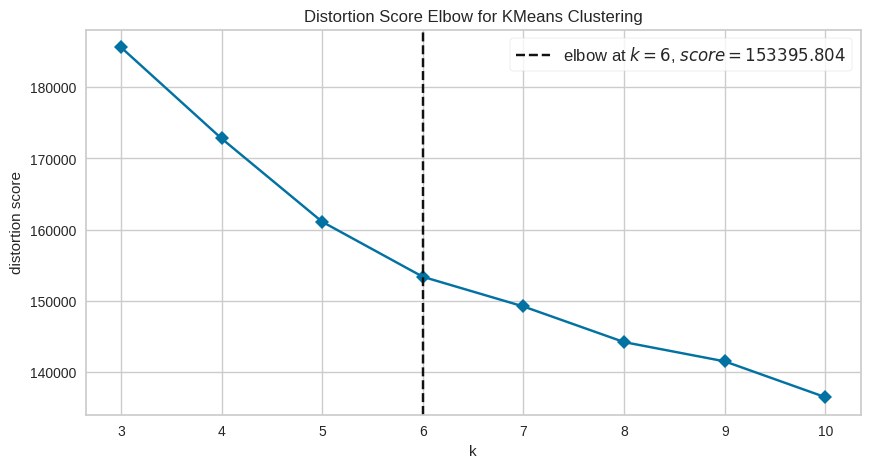

In [ ]:
model2 = KMeans(init=init,              #Se define el método de inicialización. 
               n_init=n_init,           #Número de inicializaciones aleatorias. Al final se escoge aquel con la menor inercia: sum( (x_i-centroide(x_i))^2 ). 
               max_iter=max_iter,       #Número MÁXIMO de iteraciones para una sola ejecución.
               random_state=random_seed)

for metric in ["distortion"]:  #Itere sobre las métricas que soporta KElbowVisualizer.
  
  kmin_ = kmin
  
  plt.figure(figsize=(10,5))   #Tamaño de la figura (ancho, alto).
  visualizer2 = KElbowVisualizer(estimator=model2, 
                                  k=(kmin_,kmax+1),     #Permite explorar valores de k entre [kmin_,kmax].
                                  metric=metric,        #Opciones:  "distortion", "silhouette", "calinski_harabasz"
                                  timings=False,          
                                  locate_elbow=True)   #Si esta opción se activa, ubica el codo con una línea punteada.
  visualizer2.fit(df_means)   
  visualizer2.show()

###El valor más óptimo de K nos dio 6, pero pensando en la naturaleza del problema y teniendo en cuenta que tenemos más de 800 géneros, decidimos aplicar clustering con un K = 15, lo que significa que reduciremos la cantidad de géneros a 15.

#**Se asigna el modelo a un pipeline**
***

In [ ]:
k = 15  #Número de grupos que se escogió después del análisis previo.

kmeans_pipeline = make_pipeline(
                KMeans(
                    n_clusters   = k,            #Se define el número de grupos.
                    init         = init,         #Se define el método de inicialización. Otra opción es 'random'
                    n_init       = n_init,       #Número de inicializaciones aleatorias. 
                    max_iter     = max_iter,     #Número MÁXIMO de iteraciones para una sola ejecución.
                    random_state = random_seed
                )
)

kmeans_pipeline

Pipeline(steps=[('kmeans', KMeans(n_clusters=15, n_init=10, random_state=42))])

In [ ]:
X = np.array(df_means)
X.shape

(48761, 848)

In [ ]:
df_means.head()

,"""1990s""","""Beat em up""","""Shoot Em Up""",1980s,2.5D,2D,2D Fighter,2D Platformer,360 Video,3D,...,Feature Film,Fox,Hobby Sim,price_final,positive_ratio,rating,is_recommended,win,mac,linux
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2.313068,1.196660,7,1,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1.155955,1.092603,7,1,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.345977,1.105610,6,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1.734511,1.196660,7,0,1,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1.734511,0.793438,4,1,1,0,0


In [ ]:
kmeans_pipeline.fit(df_means)
kmeans_pipeline.named_steps

{'kmeans': KMeans(n_clusters=15, n_init=10, random_state=42)}

In [ ]:
modelo_kmeans = kmeans_pipeline.named_steps['kmeans']

In [ ]:
labels = modelo_kmeans.predict(X)
labels.shape

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


(48761,)

In [ ]:
centroides = modelo_kmeans.cluster_centers_
centroides.shape

(15, 848)

In [ ]:
df_means['Cluster No'] = modelo_kmeans.labels_
df_means["app_id"] = df_prueba["app_id"]
df_means.head()

,"""1990s""","""Beat em up""","""Shoot Em Up""",1980s,2.5D,2D,2D Fighter,2D Platformer,360 Video,3D,...,Hobby Sim,price_final,positive_ratio,rating,is_recommended,win,mac,linux,Cluster No,app_id
0,0,0,0,0,0,0,0,0,0,0,...,0,2.313068,1.196660,7,1,1,0,0,0,10090.0
1,0,0,0,0,0,0,0,0,0,0,...,0,1.155955,1.092603,7,1,1,0,0,10,13500.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0.345977,1.105610,6,0,1,0,0,11,22364.0
3,0,0,0,0,0,0,0,0,0,0,...,0,1.734511,1.196660,7,0,1,1,1,7,113020.0
4,0,0,0,0,0,0,0,0,0,0,...,0,1.734511,0.793438,4,1,1,0,0,3,226560.0


##Se verifican qué tantos juegos quedaron asignados a cada color

In [ ]:
colores=['black','green','gold', 'blue', 'red', 'white', 'purple', 'brown', "orange", "purple", "gray", "magenta", "lime", "silver", "yellow"]
copy =  pd.DataFrame()
copy['app_id'] = df_prueba['app_id'].values
copy['cluster'] = df_means['Cluster No'].values
copy['label'] = labels;
cantidadGrupo =  pd.DataFrame()
cantidadGrupo['color']=colores
cantidadGrupo['cantidad']=copy.groupby('label').size()
cantidadGrupo

,color,cantidad
0,black,4482
1,green,2557
2,gold,3516
3,blue,3656
4,red,4999
5,white,21
6,purple,6445
7,brown,3911
8,orange,1121
9,purple,2685


####Se ve la distribución a apartir de una gráfica de pastel.

([<matplotlib.patches.Wedge at 0x7f141fbafa00>,
 [Text(1.0065210432416507, 0.4437514952219761, '0'),
  Text(0.4467648809625823, 1.0051871174753932, '10'),
  Text(-0.2461251784873787, 1.0721111866381006, '11'),
  Text(-0.8163471807694949, 0.7372769360624933, '7'),
  Text(-1.0811176790061883, 0.20293980422842806, '3'),
  Text(-1.0418341271042089, -0.3529612607652732, '1'),
  Text(-0.7443755127148748, -0.8098796799960273, '13'),
  Text(-0.2815563427370084, -1.0633560202794548, '6'),
  Text(0.22202746497014922, -1.0773596450577352, '2'),
  Text(0.6236099680658488, -0.9061515368463, '9'),
  Text(0.8886339739024509, -0.6483283584930851, '8'),
  Text(1.0363946673135302, -0.36862730984569925, '4'),
  Text(1.08834936453974, -0.15967360679193163, '5'),
  Text(1.0992026713557634, -0.041874661602853476, '12'),
  Text(1.099998993324149, -0.0014881820650863586, '14')])

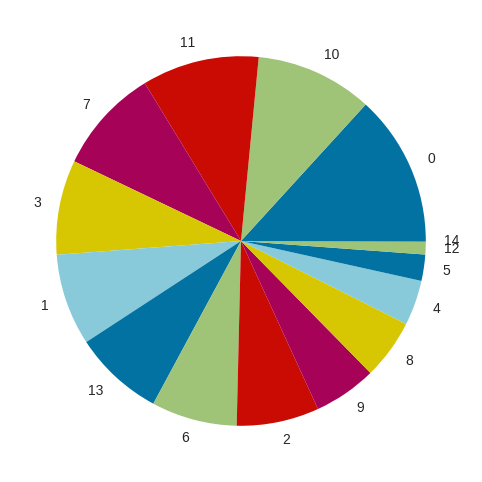

In [ ]:
serie_recommendations = df_means["Cluster No"].value_counts()

labels = df_means["Cluster No"].unique()

plt.pie(serie_recommendations, labels = labels)

##Se verifican los puntos más cercanos a los centroides

In [ ]:
closets, _ = pairwise_distances_argmin_min(modelo_kmeans.cluster_centers_, X)
closets

array([21317, 42475, 10359, 21318, 28805, 28387, 27512, 33942, 21339,
       19371, 27701, 48620,  6177, 47179, 30839])

In [ ]:
gamesArr = df_prueba['app_id'].values

for row in closets:
    print(gamesArr[row])

2067780.0
409760.0
395239.0
2307470.0
259211.0
2085510.0
40391.0
34342.0
2182370.0
347890.0
830640.0
2281460.0
1158730.0
2191800.0
315397.0


##Se observa la distribución de los clusters

In [ ]:
games["Cluster No"] = df_means["Cluster No"]

In [ ]:
def getGenres(dataframe):
  dic = {}

  for row in dataframe['genre']:
    for genre in row:
      if(genre in dic):
        dic[genre] += 1
      else:
        dic[genre] = 1
  
  return dict(sorted(dic.items(), key=lambda item:item[1], 
                                reverse=True))

In [ ]:
for number in games['Cluster No'].unique():
  print(number, getGenres(games[games["Cluster No"] == number]))

0 {'Singleplayer': 2921, 'Adventure': 2122, 'Action': 2044, 'Indie': 1958, 'Simulation': 1382, 'Story Rich': 1308, 'Atmospheric': 1234, 'RPG': 1077, '2D': 1077, 'Casual': 1070, 'Strategy': 1038, 'Multiplayer': 976, 'Anime': 842, 'Exploration': 834, 'Great Soundtrack': 807, 'Fantasy': 785, 'Cute': 768, 'First-Person': 734, 'Funny': 696, 'Early Access': 695, 'Female Protagonist': 693, 'Open World': 672, 'Colorful': 671, '3D': 668, 'Puzzle': 641, 'Sci-fi': 624, 'Co-op': 566, 'Sandbox': 551, 'Difficult': 526, 'Visual Novel': 502, 'Family Friendly': 492, 'Pixel Graphics': 491, 'Comedy': 489, 'Shooter': 478, 'Third Person': 477, 'Choices Matter': 438, 'Horror': 434, 'Action-Adventure': 434, 'Realistic': 408, 'Platformer': 407, 'Retro': 406, 'VR': 405, 'Violent': 384, 'Controller': 373, 'FPS': 372, 'Gore': 367, 'Sexual Content': 367, 'Arcade': 360, 'Survival': 359, 'Relaxing': 356, 'Building': 352, 'Multiple Endings': 350, 'Physics': 349, 'Management': 338, 'Mystery': 337, 'Nudity': 331, 'Cha

###Se cambian los valores numéricos de los géneros por valores categóricos

In [ ]:
new_df = pd.DataFrame()
new_df["genre"] = df_means["Cluster No"]
new_df["price_final"] = df_means["price_final"]
new_df["positive_ratio"] = df_means["positive_ratio"]
new_df["win"] = df_means["win"]
new_df["mac"] = df_means["mac"]
new_df["linux"] = df_means["linux"]
new_df["app_id"] = df_means["app_id"]

new_df.head()

,genre,price_final,positive_ratio,win,mac,linux,app_id
0,0,2.313068,1.196660,1,0,0,10090.0
1,10,1.155955,1.092603,1,0,0,13500.0
2,11,0.345977,1.105610,1,0,0,22364.0
3,7,1.734511,1.196660,1,1,1,113020.0
4,3,1.734511,0.793438,1,0,0,226560.0


In [ ]:
#0 Singleplayer
#1 RPG
#2 Atmospheric
#3 Simulation
#4 Action
#5 Animation & Modeling
#6 Indie
#7 2D
#8 Open World
#9 Free to Play
#10 Adventure
#11 Casual
#12 Strategy
#13 Story Rich
#14 Horror

rows, cols = new_df.shape
listGenres = ["Singleplayer", "RPG", "Atmospheric", "Simulation", "Action", "Animation & Modeling", "Indie", "2D", "Open World", "Free to Play", "Adventure", "Casual", "Strategy", "Story Rich", "Horror"]

for i in range(len(listGenres)):
  new_df["genre"] = new_df["genre"].replace(i, listGenres[i]) 

In [ ]:
new_df.head()

,genre,price_final,positive_ratio,win,mac,linux,app_id
0,Singleplayer,2.313068,1.196660,1,0,0,10090.0
1,Adventure,1.155955,1.092603,1,0,0,13500.0
2,Casual,0.345977,1.105610,1,0,0,22364.0
3,2D,1.734511,1.196660,1,1,1,113020.0
4,Simulation,1.734511,0.793438,1,0,0,226560.0


([<matplotlib.patches.Wedge at 0x7f140a5eae30>,
 [Text(1.0065210432416507, 0.4437514952219761, 'Singleplayer'),
  Text(0.4467648809625823, 1.0051871174753932, 'Adventure'),
  Text(-0.2461251784873787, 1.0721111866381006, 'Casual'),
  Text(-0.8163471807694949, 0.7372769360624933, '2D'),
  Text(-1.0811176790061883, 0.20293980422842806, 'Simulation'),
  Text(-1.0418341271042089, -0.3529612607652732, 'RPG'),
  Text(-0.7443755127148748, -0.8098796799960273, 'Story Rich'),
  Text(-0.2815563427370084, -1.0633560202794548, 'Indie'),
  Text(0.22202746497014922, -1.0773596450577352, 'Atmospheric'),
  Text(0.6236099680658488, -0.9061515368463, 'Free to Play'),
  Text(0.8886339739024509, -0.6483283584930851, 'Open World'),
  Text(1.0363946673135302, -0.36862730984569925, 'Action'),
  Text(1.08834936453974, -0.15967360679193163, 'Animation & Modeling'),
  Text(1.0992026713557634, -0.041874661602853476, 'Strategy'),
  Text(1.099998993324149, -0.0014881820650863586, 'Horror')])

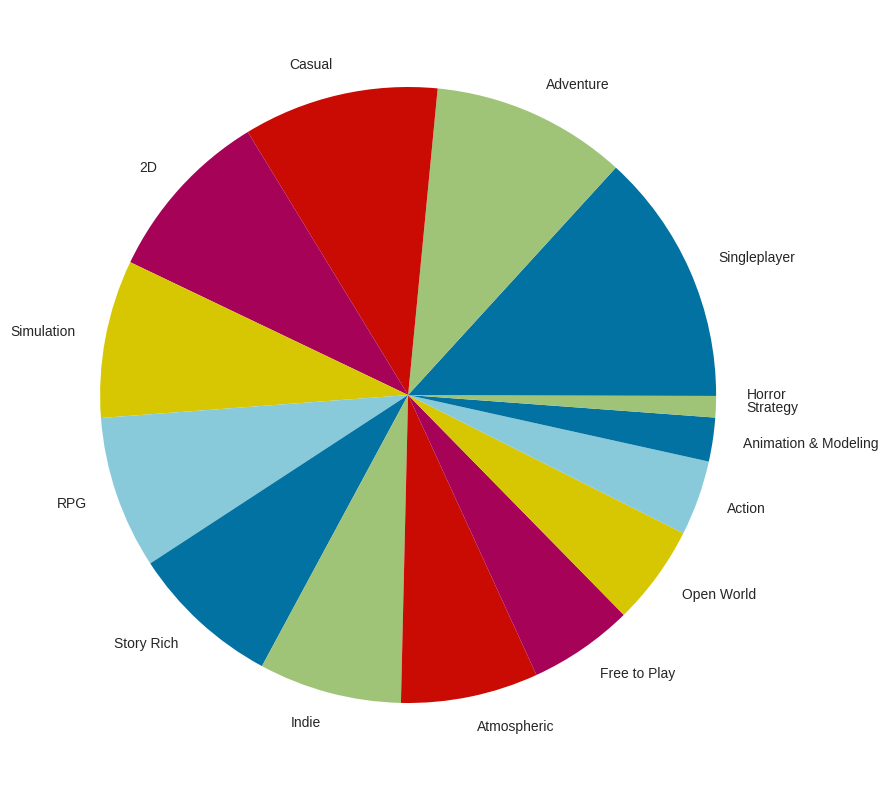

In [ ]:
serie_recommendations = new_df["genre"].value_counts()

labels = new_df["genre"].unique()

fig = plt.figure(figsize=(20, 10))

plt.pie(serie_recommendations, labels = labels)

In [ ]:
new_df.shape

(48761, 7)

#Exportar el modelo 
----------------------------------------------

###Volvemos a pasar los valores normalizados a como estaban en un principio


In [ ]:
new_df['positive_ratio'] = new_df["positive_ratio"]*meanOfRatio
new_df['price_final'] = new_df["price_final"]*meanOfPrice

In [ ]:
new_df.head()

,genre,price_final,positive_ratio,win,mac,linux,app_id
0,Singleplayer,90495.7295,92.0,1,0,0,10090.0
1,Adventure,45225.2295,84.0,1,0,0,13500.0
2,Casual,13535.8795,85.0,1,0,0,22364.0
3,2D,67860.4795,92.0,1,1,1,113020.0
4,Simulation,67860.4795,61.0,1,0,0,226560.0


In [ ]:
!pip install pycaret

In [ ]:
from pycaret.clustering import setup, create_model, save_model, get_config, assign_model

kmeans = setup(new_df, session_id = 123)

,Description,Value
0,Session id,123
1,Original data shape,"(48761, 7)"
2,Transformed data shape,"(48761, 21)"
3,Numeric features,6
4,Categorical features,1
5,Preprocess,True
6,Imputation type,simple
7,Numeric imputation,mean
8,Categorical imputation,mode
9,Maximum one-hot encoding,-1


In [ ]:
model = create_model('kmeans', 15)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4198,265358.0390,0.7268,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
save_model(model, model_name = 'kmeans_deployment')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['price_final', 'positive_ratio',
                                              'win', 'mac', 'linux', 'app_id'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['genre'],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('onehot_encoding',
                  TransformerWrapper(include=['genre'],
                                     transformer=OneHotEncoder(cols=['genre'],
                                                               handle_missing='return_nan',
                                                               use_cat_names=True))),
                 ('trained_model', KMeans(n_clusters=15, random_state=123))]),
 'kmeans_deployment.pkl')

In [ ]:
df = pd.DataFrame()
df["app_id"] = new_df["app_id"]
df["title"] = games["title"]
df["price_final"] = new_df["price_final"]
df["win"] = new_df["win"]
df["mac"] = new_df["mac"]
df["linux"] = new_df["linux"]
df["genre"] = new_df["genre"]

df.head()

,app_id,title,price_final,win,mac,linux,genre
0,10090.0,Call of Duty: World at War,90495.7295,1,0,0,Singleplayer
1,13500.0,Prince of Persia: Warrior Within™,45225.2295,1,0,0,Adventure
2,22364.0,BRINK: Agents of Change,13535.8795,1,0,0,Casual
3,113020.0,Monaco: What's Yours Is Mine,67860.4795,1,1,1,2D
4,226560.0,Escape Dead Island,67860.4795,1,0,0,Simulation


In [ ]:
df.to_csv('dataframe.csv', index=False)

In [ ]:
df.loc[df["genre"] == "Action"]

,app_id,title,price_final,win,mac,linux,genre
35,462280.0,Offworld Trading Company - Soundtrack DLC,45225.2295,1,1,0,Action
89,436550.0,Homeworld: Deserts of Kharak - Soundtrack,36171.1295,1,1,0,Action
91,439500.0,LEGO® MARVEL's Avengers DLC - The Masters of E...,13535.8795,1,0,0,Action
129,765770.0,Forest Legends: The Call of Love Collector's E...,45225.2295,1,0,0,Action
141,480520.0,Street Fighter V - Capcom Pro Tour 2016 Pack,22589.9795,1,0,0,Action
...,...,...,...,...,...,...,...
48729,1611960.0,Doomed Lands,54279.3295,1,0,0,Action
48731,2321091.0,NTBSS: Master Character Training Pack - Minato...,18062.9295,1,0,0,Action
48733,1394370.0,Tebb and the chistorbes,0.0000,1,0,0,Action
48735,1200960.0,Master Of Pottery - OST,0.0000,0,0,0,Action
